In [6]:
# --- Cell 1: Setup (run once) ---
%pip -q install imbalanced-learn shap tensorflow scikeras missingno

Note: you may need to restart the kernel to use updated packages.


In [7]:
# --- Cell 2: Imports & helpers ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings, os, math
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, average_precision_score
)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

import shap, missingno as msno

RNG = 42

def eval_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"== {title} ==")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred), 4))
    print("Recall   :", round(recall_score(y_true, y_pred), 4))
    print("F1       :", round(f1_score(y_true, y_pred), 4))
    try:
        print("ROC-AUC  :", round(roc_auc_score(y_true, y_prob), 4))
    except:
        pass
    print("AP (PR-AUC):", round(average_precision_score(y_true, y_prob), 4))
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix {title}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar(im); plt.show()


In [8]:
# --- Cell 3: Load dataset ---
DATA_PATH = Path("data.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


== BASIC SHAPE / TYPES ==
Shape: (7043, 21)

Column Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

== MISSING VALUES ==
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV      

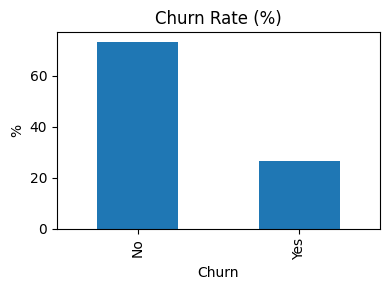


Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns    : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


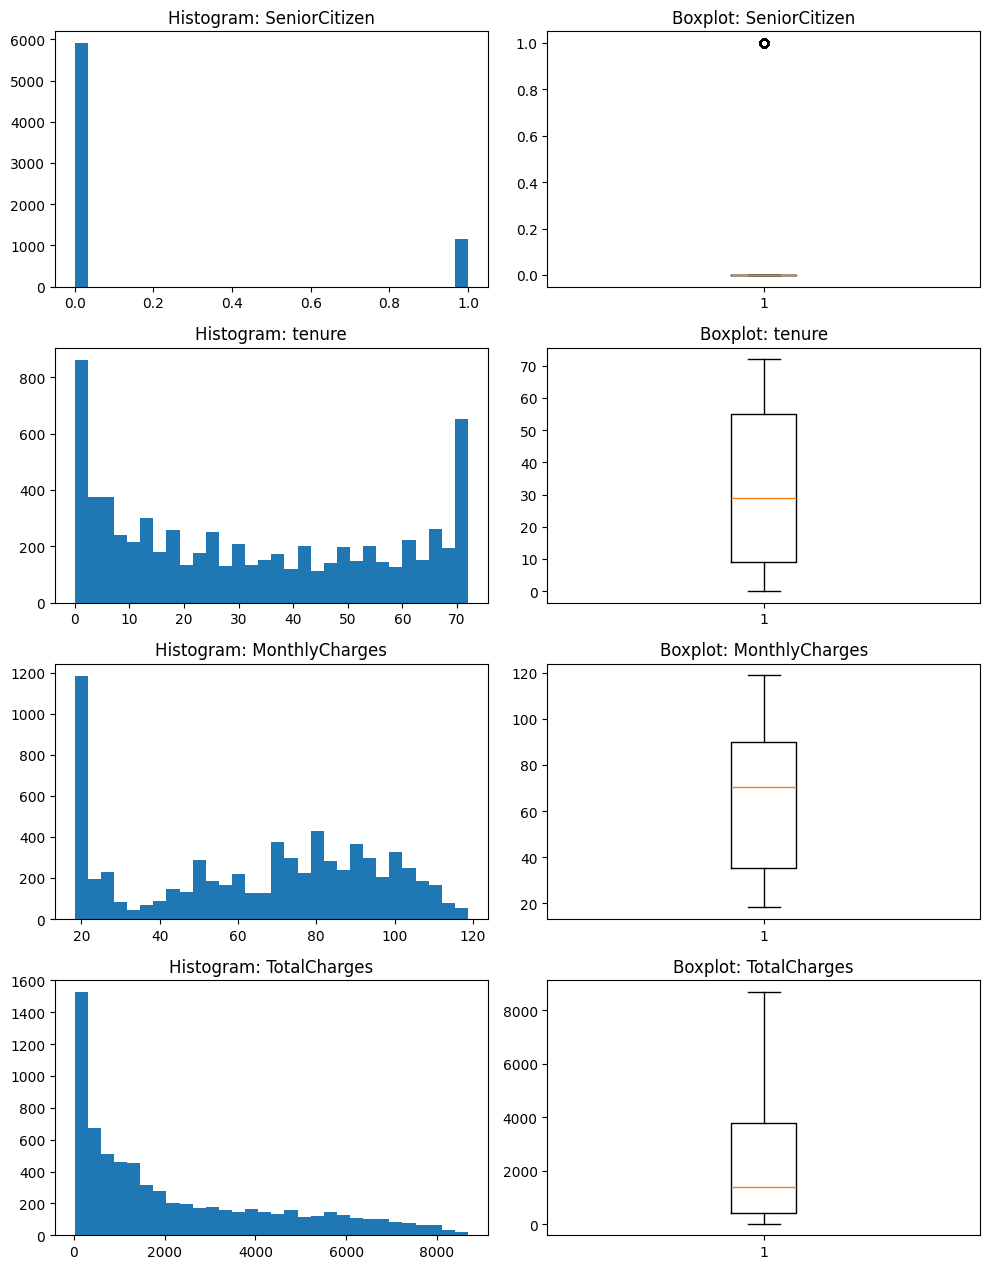

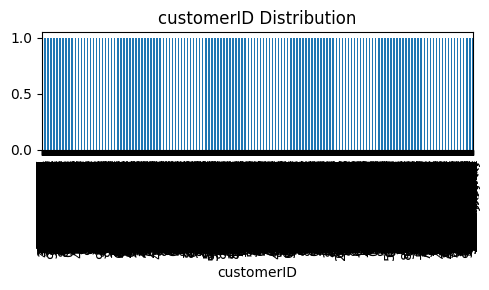

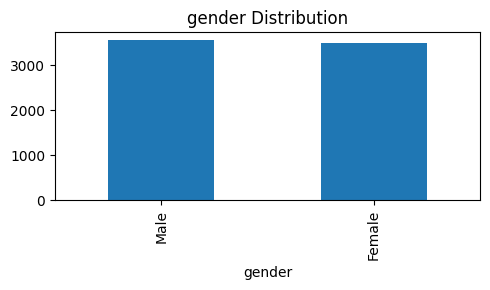

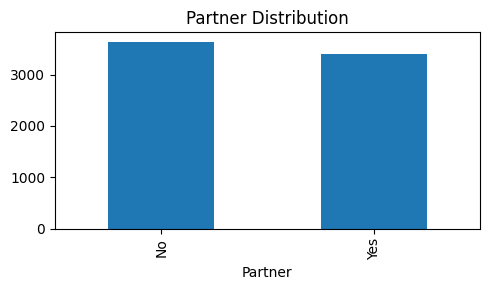

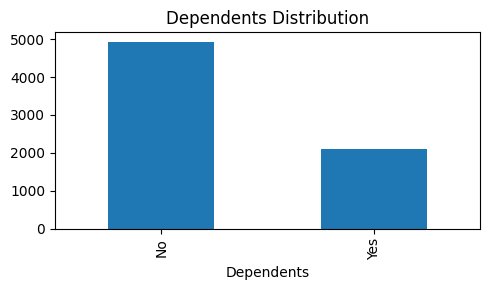

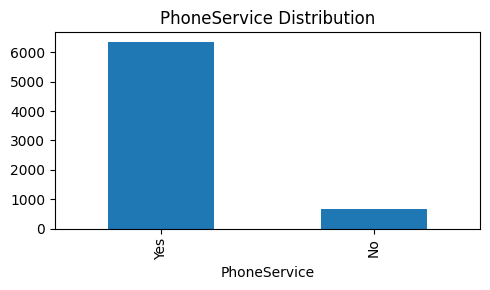

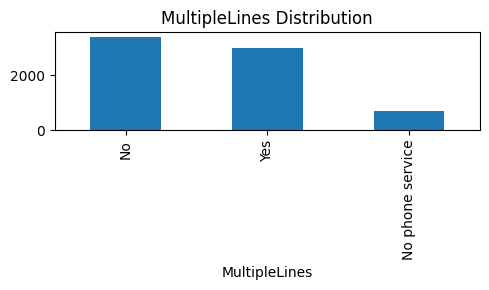

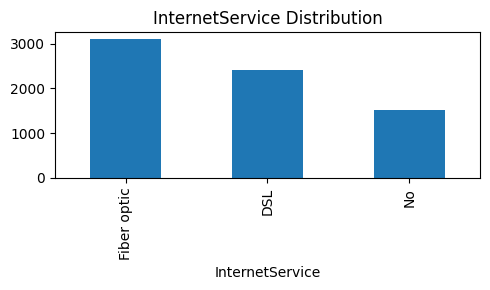

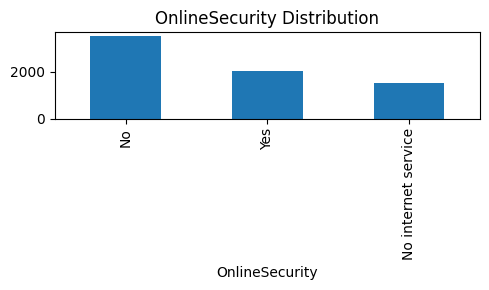

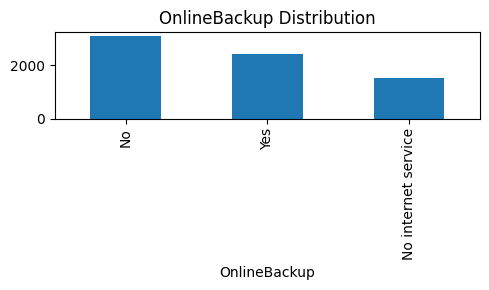

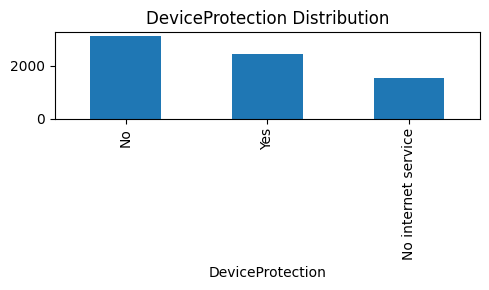

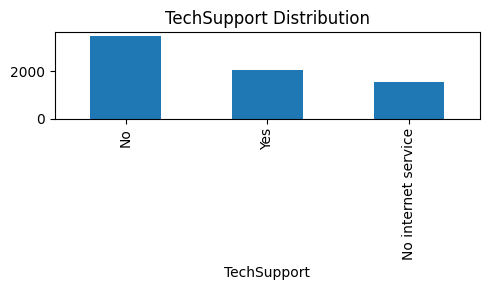

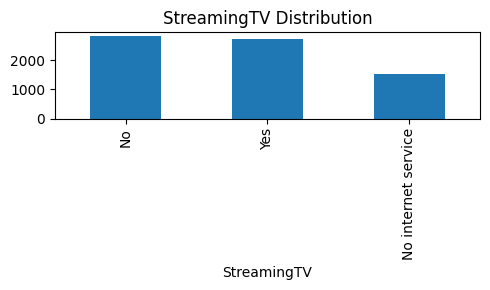

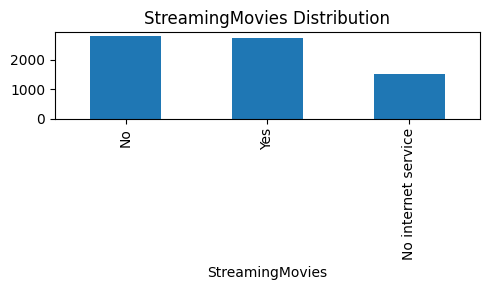

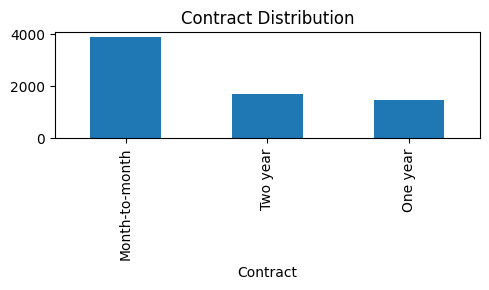

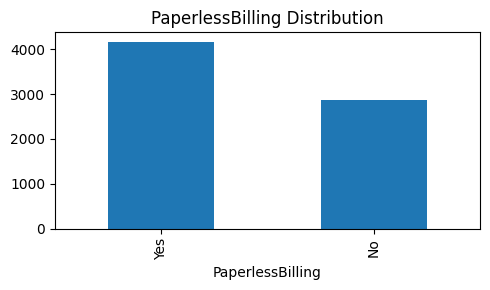

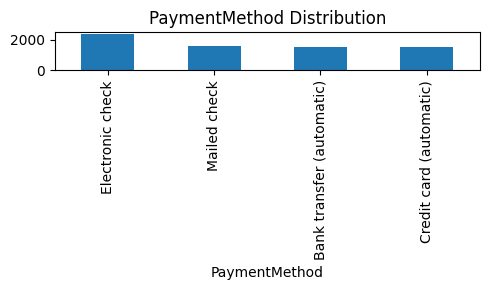

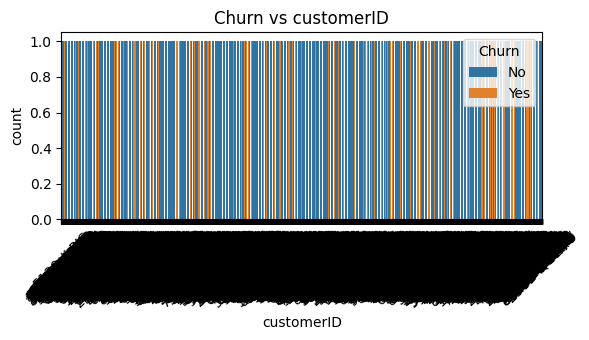

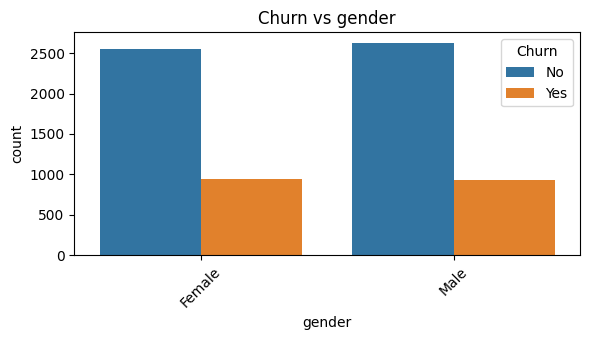

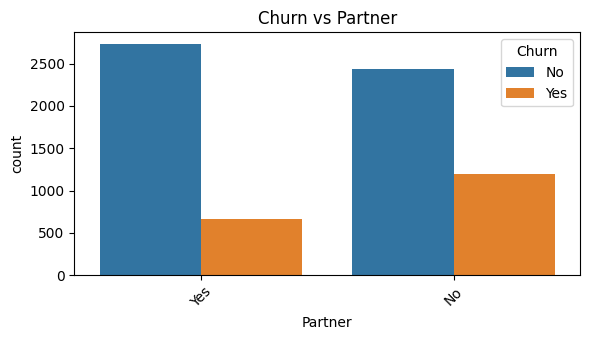

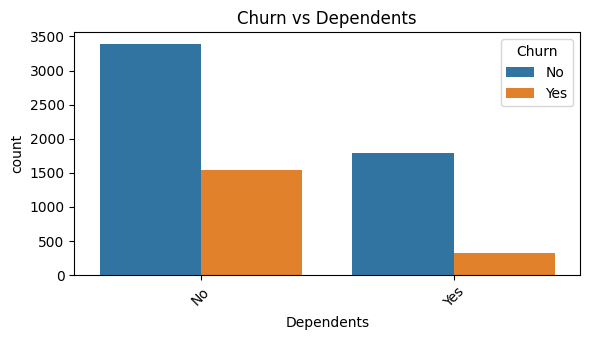

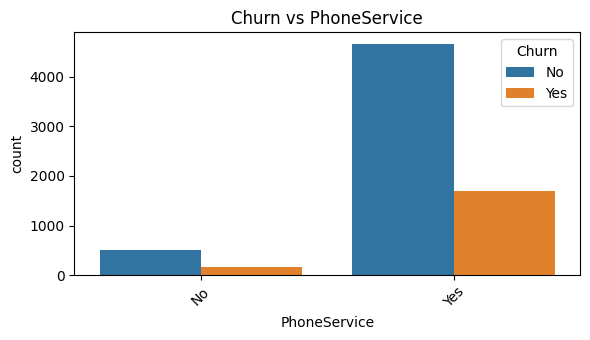

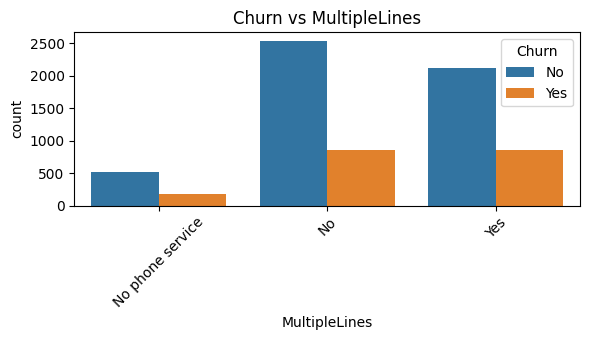

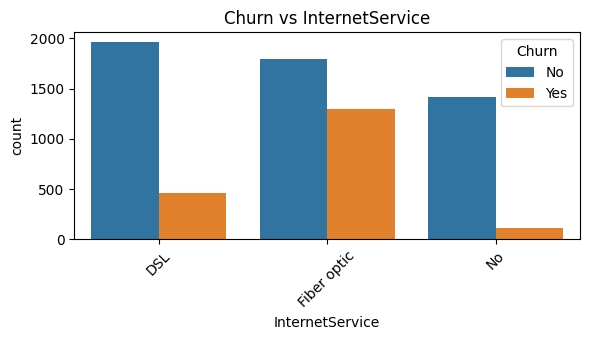

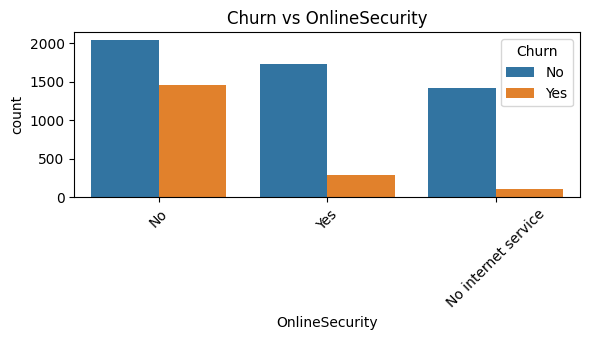

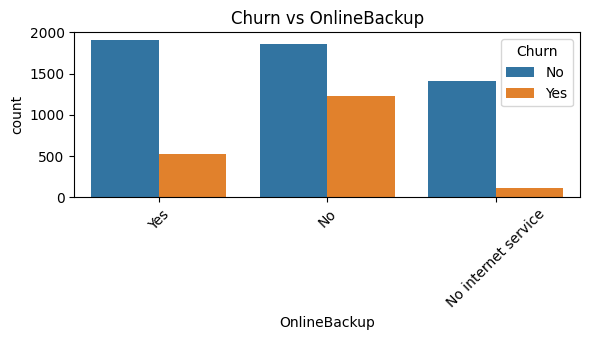

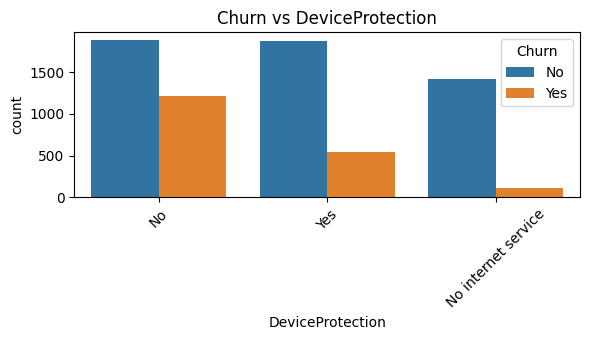

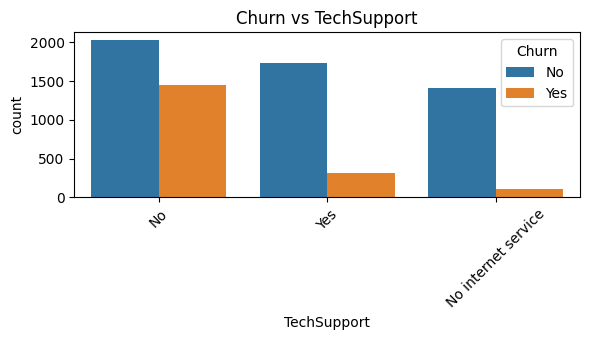

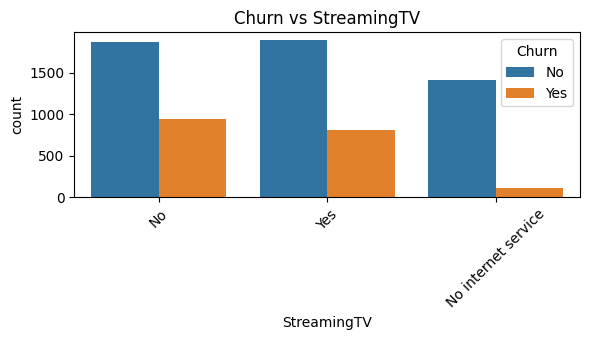

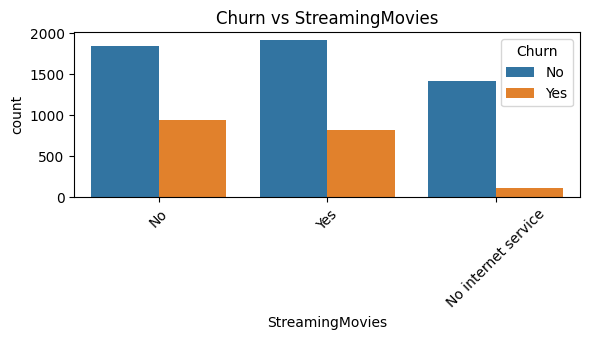

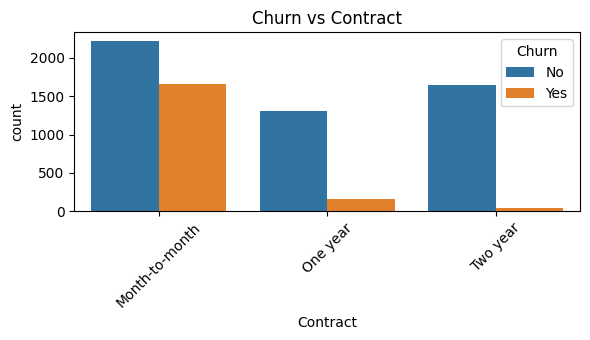

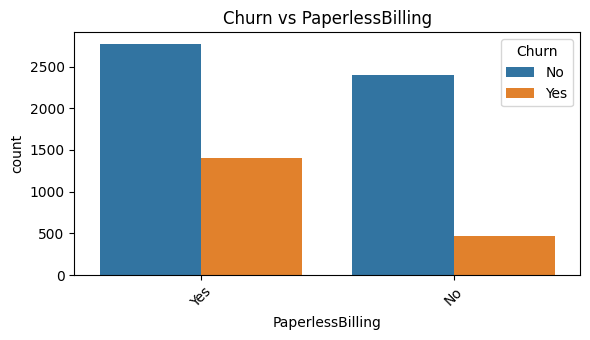

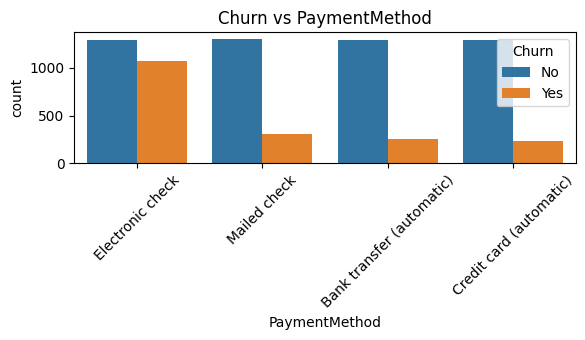

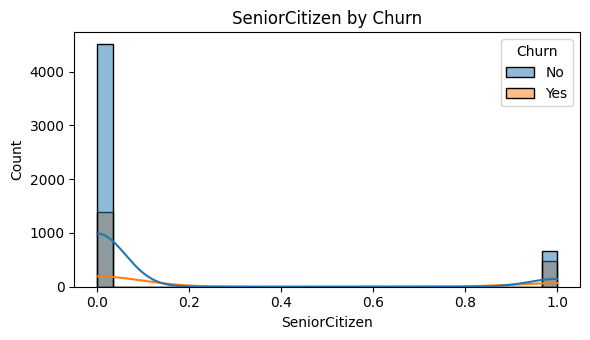

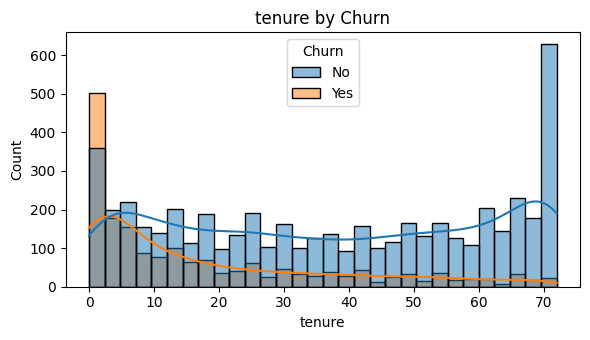

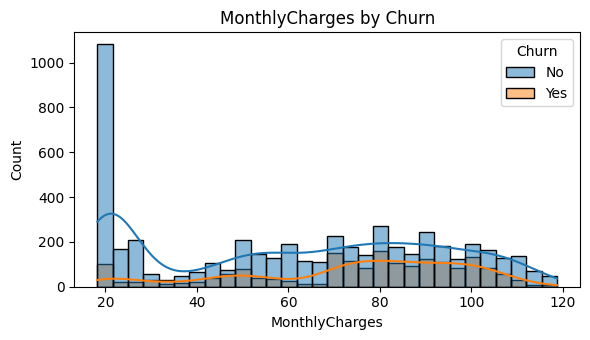

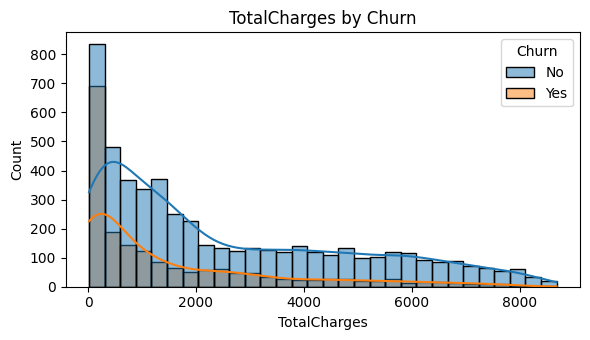

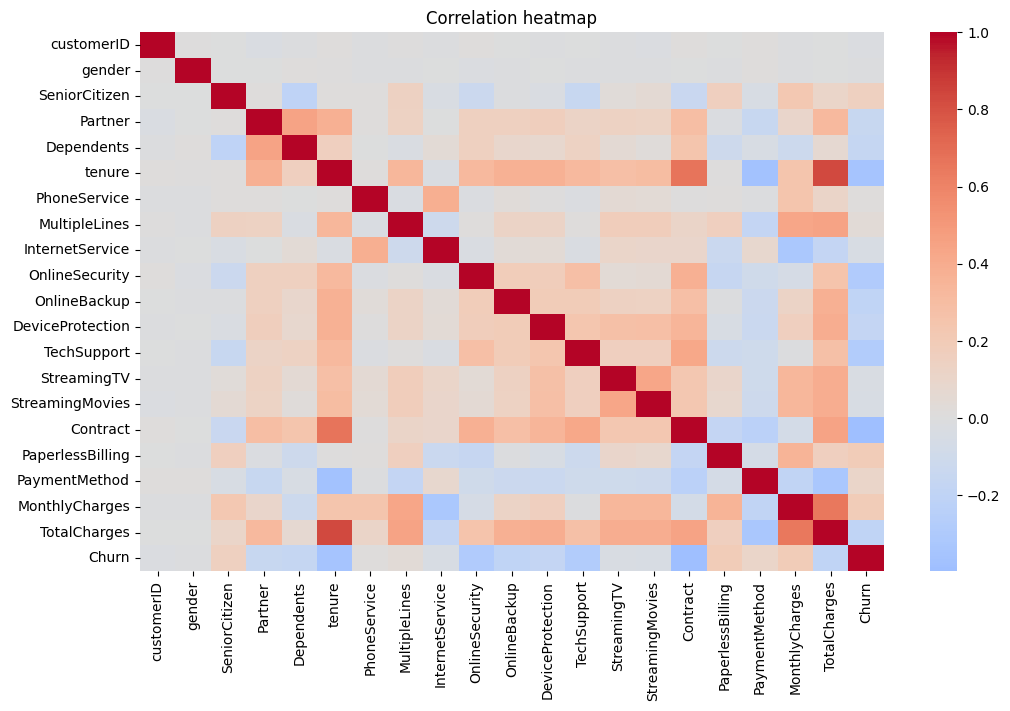


Top correlations with target:
Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
customerID         -0.017447
StreamingTV        -0.036581
StreamingMovies    -0.038492
InternetService    -0.047291
Name: Churn, dtype: float64


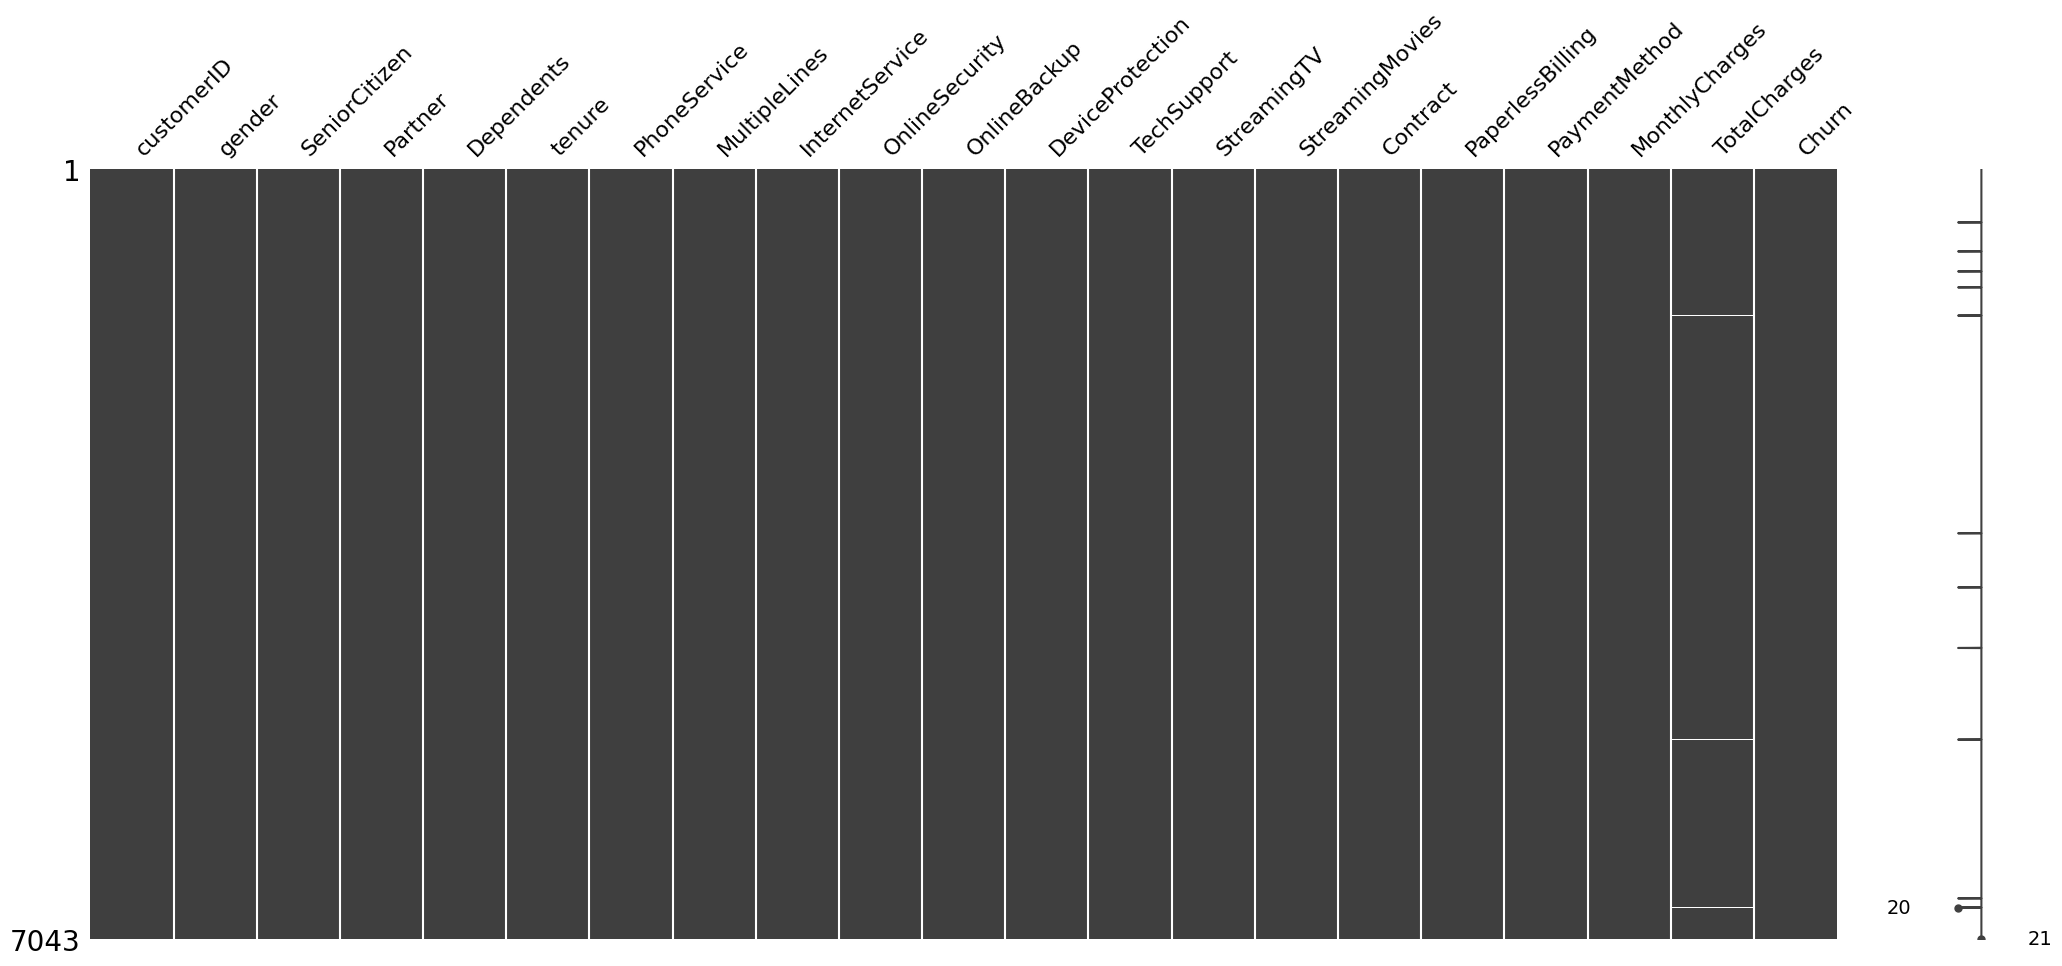


Outlier counts (IQR method): {'SeniorCitizen': 1142, 'tenure': 0, 'MonthlyCharges': 0, 'TotalCharges': 0}


In [9]:
# --- Cell 4: FULL EDA (combined in one cell, auto-detects target) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import pandas as pd

# Safety check
assert isinstance(df, pd.DataFrame) and not df.empty, "`df` must be loaded before running EDA."

print("== BASIC SHAPE / TYPES ==")
print("Shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)

# Work on a copy for EDA
df_eda = df.copy()

# Common Telco quirk: 'TotalCharges' is str with blanks — coerce to numeric if present
if "TotalCharges" in df_eda.columns:
    df_eda["TotalCharges"] = pd.to_numeric(df_eda["TotalCharges"], errors="coerce")

print("\n== MISSING VALUES ==")
print(df_eda.isna().sum())

# -----------------------------
# Target detection (robust)
# -----------------------------
common_targets = ["Churn","churn","Target","target","Label","label","Outcome","outcome","Class","class","y"]
TARGET_NAME = next((c for c in common_targets if c in df_eda.columns), None)

if TARGET_NAME is None:
    # Fallback: pick a binary column as target (prefer the last one)
    binary_like = [c for c in df_eda.columns if df_eda[c].nunique(dropna=True) == 2]
    if binary_like:
        TARGET_NAME = binary_like[-1]
    else:
        raise AssertionError("Target column not found. Please rename your target to 'Churn' or set TARGET_NAME manually.")

print(f"\nDetected target column: {TARGET_NAME}")

# -----------------------------
# Target distribution + rate
# -----------------------------
print(f"\n== {TARGET_NAME} DISTRIBUTION ==")
print(df_eda[TARGET_NAME].value_counts(dropna=False))

# Try to compute positive rate in a sensible way
pos_rate = None
try:
    vals = df_eda[TARGET_NAME].dropna()
    if set(map(str, vals.unique())) <= {"Yes","No","yes","no"}:
        pos_rate = (vals.astype(str).str.lower() == "yes").mean() * 100
    elif np.issubdtype(vals.dtype, np.number):
        # Prefer label '1' if present, otherwise the larger numeric class as "positive"
        pos_label = 1 if 1 in vals.unique() else vals.max()
        pos_rate = (vals == pos_label).mean() * 100
    else:
        # Fallback: choose minority class as "positive" proxy just for rate display
        counts = vals.value_counts(normalize=True)
        pos_rate = counts.min() * 100
    print(f"{TARGET_NAME} positive rate (% approx.): {pos_rate:.2f}")
except Exception as e:
    print("Could not compute positive rate:", e)

# Bar chart of target
plt.figure(figsize=(4,3))
df_eda[TARGET_NAME].value_counts(normalize=True).mul(100).plot(kind='bar')
plt.title(f"{TARGET_NAME} Rate (%)"); plt.ylabel("%"); plt.tight_layout(); plt.show()

# -----------------------------
# Identify numeric / categorical (excluding target)
# -----------------------------
cat_cols_eda = [c for c in df_eda.columns if df_eda[c].dtype == "object" and c != TARGET_NAME]
num_cols_eda = [c for c in df_eda.columns if c not in cat_cols_eda + [TARGET_NAME]]

print("\nCategorical columns:", cat_cols_eda)
print("Numeric columns    :", num_cols_eda)

# -----------------------------
# Numeric distributions + boxplots
# -----------------------------
if len(num_cols_eda) > 0:
    n = len(num_cols_eda)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 3.2*n))
    if n == 1:
        axes = np.array([axes])  # make it 2D
    for i, col in enumerate(num_cols_eda):
        axes[i,0].hist(df_eda[col].dropna(), bins=30)
        axes[i,0].set_title(f"Histogram: {col}")
        axes[i,1].boxplot(df_eda[col].dropna())
        axes[i,1].set_title(f"Boxplot: {col}")
    plt.tight_layout(); plt.show()

# -----------------------------
# Categorical distributions
# -----------------------------
for col in cat_cols_eda:
    plt.figure(figsize=(5,3))
    df_eda[col].value_counts().plot(kind='bar')
    plt.title(f"{col} Distribution"); plt.tight_layout(); plt.show()

# -----------------------------
# Target vs Categorical (countplot)
# -----------------------------
for col in cat_cols_eda:
    plt.figure(figsize=(6,3.5))
    sns.countplot(data=df_eda, x=col, hue=TARGET_NAME)
    plt.title(f"{TARGET_NAME} vs {col}")
    plt.xticks(rotation=45)
    plt.tight_layout(); plt.show()

# -----------------------------
# Target vs Numeric (histplot with hue)
# -----------------------------
for col in num_cols_eda:
    plt.figure(figsize=(6,3.5))
    try:
        sns.histplot(data=df_eda, x=col, hue=TARGET_NAME, kde=True, bins=30)
    except Exception:
        # If hue type clashes, cast to string
        temp = df_eda.copy()
        temp[TARGET_NAME] = temp[TARGET_NAME].astype(str)
        sns.histplot(data=temp, x=col, hue=TARGET_NAME, kde=True, bins=30)
    plt.title(f"{col} by {TARGET_NAME}")
    plt.tight_layout(); plt.show()

# -----------------------------
# Correlation Heatmap (encode categoricals + possibly encode target)
# -----------------------------
df_corr = df_eda.copy()
for c in df_corr.columns:
    if df_corr[c].dtype == "object":
        df_corr[c] = df_corr[c].astype("category").cat.codes

plt.figure(figsize=(12,7))
sns.heatmap(df_corr.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation heatmap"); plt.show()

if TARGET_NAME in df_corr.columns:
    print("\nTop correlations with target:")
    print(df_corr.corr(numeric_only=True)[TARGET_NAME].sort_values(ascending=False).head(12))

# -----------------------------
# Missingness matrix (visual)
# -----------------------------
try:
    msno.matrix(df_eda)
    plt.show()
except Exception as e:
    print("missingno plot skipped:", e)

# -----------------------------
# Outlier quick check (IQR)
# -----------------------------
outlier_report = {}
for col in num_cols_eda:
    Q1, Q3 = df_eda[col].quantile(0.25), df_eda[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    count = df_eda[(df_eda[col] < lower) | (df_eda[col] > upper)][col].count()
    outlier_report[col] = int(count)

print("\nOutlier counts (IQR method):", outlier_report)


In [10]:
# --- Cell 5 (FIXED): Cleaning + feature engineering + target (robust target detection) ---
import numpy as np
import pandas as pd

df = df.copy()

# -----------------------------
# 0) Detect target column robustly
# -----------------------------
def detect_target(dataframe: pd.DataFrame) -> str:
    # Try exact common names
    common = ["Churn","churn","Target","target","Label","label","Outcome","outcome","Class","class","y"]
    for name in common:
        if name in dataframe.columns:
            return name

    # Try case-insensitive / stripped matches
    norm_map = {c: c.strip().lower() for c in dataframe.columns}
    inv_map  = {v: k for k, v in norm_map.items()}
    for cand in ["churn","target","label","outcome","class","y"]:
        if cand in inv_map:
            return inv_map[cand]

    # Fallback: any binary column
    binary_like = [c for c in dataframe.columns if dataframe[c].nunique(dropna=True) == 2]
    if binary_like:
        return binary_like[-1]

    raise AssertionError("Target column not found. Rename your target to something like 'Churn' or set TARGET_NAME manually.")

# Use TARGET_NAME from the EDA cell if it exists; otherwise detect again
try:
    TARGET_NAME  # noqa: F821
except NameError:
    TARGET_NAME = detect_target(df)

print("Using TARGET_NAME:", TARGET_NAME)

# -----------------------------
# 1) Drop ID/leakage columns if present
# -----------------------------
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# -----------------------------
# 2) Fix numeric-like strings (Telco quirk)
# -----------------------------
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# -----------------------------
# 3) Feature engineering (safe guards)
# -----------------------------
if "tenure" in df.columns and "TotalCharges" in df.columns:
    df["AvgChargesPerMonth"] = df.apply(
        lambda r: (r["TotalCharges"]/r["tenure"]) if (pd.notna(r["TotalCharges"]) and pd.notna(r["tenure"]) and r["tenure"]>0)
                  else np.nan,
        axis=1
    )

if "tenure" in df.columns:
    bins = [-np.inf, 6, 12, 24, 48, np.inf]
    labels = ["≤6m", "6–12m", "1–2y", "2–4y", "≥4y"]
    df["tenure_bucket"] = pd.cut(df["tenure"], bins=bins, labels=labels)

# -----------------------------
# 4) Build binary y robustly
# -----------------------------
y_raw = df[TARGET_NAME]

def to_binary(series: pd.Series) -> pd.Series:
    s = series.copy()

    # If boolean → 0/1
    if s.dtype == bool:
        return s.astype(int)

    # If numeric and only 2 unique values → map min->0, max->1
    if np.issubdtype(s.dropna().dtype, np.number):
        uniq = np.sort(s.dropna().unique())
        if len(uniq) == 2:
            return (s == uniq.max()).astype(int)

    # String-like maps (yes/no, true/false, y/n)
    s_str = s.astype(str).str.strip().str.lower()
    if set(s_str.dropna().unique()) <= {"yes","no","true","false","y","n","1","0"}:
        pos = s_str.isin({"yes","true","y","1"})
        return pos.astype(int)

    # Last resort: treat minority class as positive (binary)
    if s.nunique(dropna=True) == 2:
        major = s.value_counts().idxmax()
        return (s != major).astype(int)

    raise AssertionError("Target must be binary. Found more than 2 classes and no obvious mapping.")

y = to_binary(y_raw).values

# -----------------------------
# 5) Define X, cat_cols, num_cols
# -----------------------------
X = df.drop(columns=[TARGET_NAME])

cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Target positive rate:", round(y.mean(), 4))
print("Categorical cols:", cat_cols)
print("Numeric cols    :", num_cols)


Using TARGET_NAME: Churn
Target positive rate: 0.2654
Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bucket']
Numeric cols    : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']


In [11]:
# --- Cell 6: Splits ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=RNG, stratify=y_train
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (4507, 21) Val: (1127, 21) Test: (1409, 21)


In [12]:
# --- Cell 7: Preprocess for SMOTENC (Ordinal) ---
pre_ord = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)
    ],
    remainder="drop"
)

# Indices of categorical columns *after* transform: numeric first, then categorical
cat_idx = list(range(len(num_cols), len(num_cols)+len(cat_cols)))
cat_idx[:5], len(cat_idx)


([5, 6, 7, 8, 9], 16)

In [13]:
# --- Cell 8: RF + SMOTENC + Tuning ---
rf = RandomForestClassifier(n_estimators=400, random_state=RNG, n_jobs=-1)

pipe_rf = ImbPipeline(steps=[
    ("pre", pre_ord),
    ("smote", SMOTENC(categorical_features=cat_idx, random_state=RNG)),
    ("rf", rf)
])

param_distrib = {
    "rf__n_estimators": [200, 300, 500, 700, 900],
    "rf__max_depth": [None, 8, 12, 16, 24, 32],
    "rf__min_samples_split": [2, 4, 8, 16],
    "rf__min_samples_leaf": [1, 2, 4, 8],
    "rf__max_features": ["sqrt", "log2", 0.5, 0.7, None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
search = RandomizedSearchCV(
    pipe_rf, param_distributions=param_distrib, n_iter=25, cv=cv,
    scoring="f1", n_jobs=-1, verbose=1, random_state=RNG
)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV f1:", round(search.best_score_, 4))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'rf__n_estimators': 700, 'rf__min_samples_split': 16, 'rf__min_samples_leaf': 8, 'rf__max_features': 'log2', 'rf__max_depth': 32}
Best CV f1: 0.6231


In [ ]:
# --- Cell 9: RF evaluation ---
best_rf = search.best_estimator_

val_prob = best_rf.predict_proba(X_val)[:,1]
eval_binary(y_val, val_prob, title="RF (Validation)")

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)
print("5-fold CV F1 on train:", np.round(cv_scores, 4), "Mean:", round(cv_scores.mean(), 4))

test_prob = best_rf.predict_proba(X_test)[:,1]
eval_binary(y_test, test_prob, title="RF (Test)")

RocCurveDisplay.from_predictions(y_test, test_prob)
plt.title("ROC — RF")
plt.show()

100%|===================| 597/600 [02:36<00:00]        

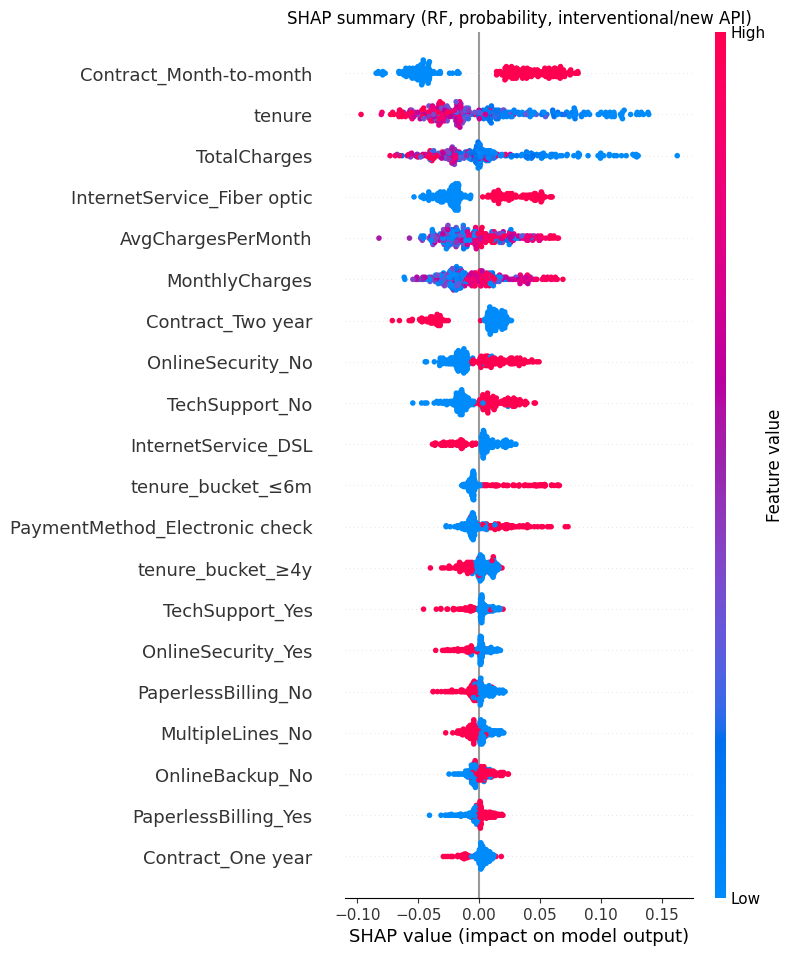

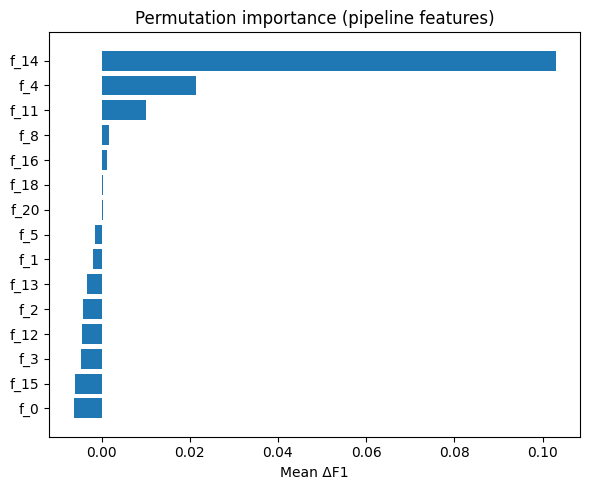

In [21]:
# --- Cell 10 (FINAL FIX): Explainability for RF with SHAP + permutation importance ---
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy import sparse

# 1) Build a readable OHE pipeline to get human-readable feature names
oh = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop"
)

X_train_oh = oh.fit_transform(X_train)
# Ensure dense
if sparse.issparse(X_train_oh):
    X_train_oh = X_train_oh.toarray()

feature_names_oh = list(num_cols) + list(
    oh.named_transformers_["cat"]["enc"].get_feature_names_out(cat_cols)
)
assert X_train_oh.shape[1] == len(feature_names_oh), "Feature names length mismatch."

# 2) Train a separate RF on OHE data (for SHAP readability)
rf_readable = RandomForestClassifier(
    n_estimators=300, random_state=RNG, n_jobs=-1, class_weight="balanced"
)
rf_readable.fit(X_train_oh, y_train)

# 3) Prepare background/sample for SHAP (faster & more stable)
rng = np.random.RandomState(RNG)
bg_size = min(200, X_train_oh.shape[0])
bg_idx = rng.choice(X_train_oh.shape[0], size=bg_size, replace=False)
X_bg = X_train_oh[bg_idx]

sample_size = min(300, X_train_oh.shape[0])
s_idx = rng.choice(X_train_oh.shape[0], size=sample_size, replace=False)
X_sample = X_train_oh[s_idx]

# 4) Build explainer — prefer new API; fall back to TreeExplainer if needed
try:
    masker = shap.maskers.Independent(X_bg)
    explainer = shap.Explainer(
        rf_readable, masker=masker, algorithm="tree", model_output="probability"
    )
    sv = explainer(X_sample, check_additivity=False)  # sv.values shape: (n_samples, n_features) or (n_samples, n_features, n_classes)
    # If multi-output, pick positive class (last dim)
    values = sv.values
    if values.ndim == 3:  # (n, p, k)
        # choose class 1 if binary, else last class
        cls_idx = 1 if values.shape[2] >= 2 else 0
        values = values[:, :, cls_idx]
    # Defensive trim if SHAP added bias as last column
    if values.shape[1] == X_sample.shape[1] + 1:
        values = values[:, :-1]
    assert values.shape[1] == X_sample.shape[1], "SHAP values/features shape mismatch after new API."
    shap.summary_plot(values, X_sample, feature_names=feature_names_oh, show=False)
    plt.title("SHAP summary (RF, probability, interventional/new API)")
    plt.show()

except Exception as e:
    # Fallback: legacy TreeExplainer
    explainer = shap.TreeExplainer(
        rf_readable,
        data=X_bg,
        feature_perturbation="interventional",
        model_output="probability"
    )
    shap_values = explainer.shap_values(X_sample, check_additivity=False)
    # For binary classifiers, SHAP returns a list [class0, class1]
    if isinstance(shap_values, list):
        sv_pos = shap_values[1]
    else:
        sv_pos = shap_values  # already an array

    # Defensive: convert sparse and trim extra bias column if present
    if sparse.issparse(sv_pos):
        sv_pos = sv_pos.toarray()
    if sv_pos.shape[1] == X_sample.shape[1] + 1:
        sv_pos = sv_pos[:, :-1]
    assert sv_pos.shape[1] == X_sample.shape[1], f"SHAP values/features shape mismatch: {sv_pos.shape} vs {X_sample.shape}"

    shap.summary_plot(sv_pos, X_sample, feature_names=feature_names_oh, show=False)
    plt.title("SHAP summary (RF, probability, interventional/legacy)")
    plt.show()

# 5) Permutation importance on the tuned pipeline (Ordinal+SMOTENC path)
perm = permutation_importance(
    estimator=best_rf, X=X_val, y=y_val,
    n_repeats=10, scoring="f1", random_state=RNG, n_jobs=-1
)
top = 15
order = np.argsort(perm.importances_mean)[::-1][:top]
plt.figure(figsize=(6,5))
plt.barh(range(len(order)), perm.importances_mean[order][::-1])
plt.yticks(range(len(order)), [f"f_{i}" for i in order][::-1])
plt.title("Permutation importance (pipeline features)")
plt.xlabel("Mean ΔF1"); plt.tight_layout(); plt.show()


In [22]:
# --- Cell 11: OHE preprocessing for Keras ---
pre_oh = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols)
    ],
    remainder="drop"
)

Xtr = pre_oh.fit_transform(X_train)
Xv  = pre_oh.transform(X_val)
Xte = pre_oh.transform(X_test)

input_dim = Xtr.shape[1]
print("Input dim:", input_dim)

Input dim: 51


Class weights: {0: 0.6806100875868317, 1: 1.8841973244147157} Pos rate: 0.2654
Epoch 1/60
18/18 - 6s - 315ms/step - auc: 0.7629 - loss: 0.7051 - precision: 0.4142 - recall: 0.7726 - val_auc: 0.8100 - val_loss: 0.5946 - val_precision: 0.5137 - val_recall: 0.6890 - learning_rate: 0.0010
Epoch 2/60
18/18 - 0s - 20ms/step - auc: 0.8040 - loss: 0.5863 - precision: 0.4709 - recall: 0.7901 - val_auc: 0.8300 - val_loss: 0.5725 - val_precision: 0.6179 - val_recall: 0.6221 - learning_rate: 0.0010
Epoch 3/60
18/18 - 0s - 22ms/step - auc: 0.8086 - loss: 0.5590 - precision: 0.4710 - recall: 0.7885 - val_auc: 0.8317 - val_loss: 0.5554 - val_precision: 0.5962 - val_recall: 0.6221 - learning_rate: 0.0010
Epoch 4/60

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 - 1s - 37ms/step - auc: 0.8311 - loss: 0.5253 - precision: 0.4942 - recall: 0.8127 - val_auc: 0.8464 - val_loss: 0.5314 - val_precision: 0.6516 - val_recall: 0.6254 - learning_rate: 0.0010
Epoch 5/60
18/18 - 

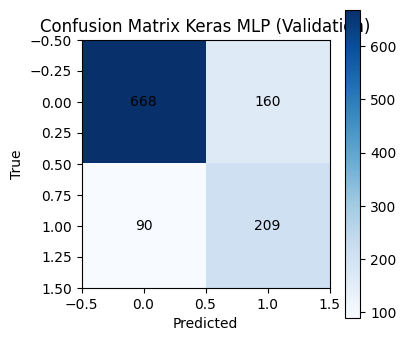

== Keras MLP (Test) ==
Accuracy : 0.77
Precision: 0.5506
Recall   : 0.7273
F1       : 0.6267
ROC-AUC  : 0.8444
AP (PR-AUC): 0.6474

Classification report:
               precision    recall  f1-score   support

           0     0.8885    0.7855    0.8338      1035
           1     0.5506    0.7273    0.6267       374

    accuracy                         0.7700      1409
   macro avg     0.7196    0.7564    0.7303      1409
weighted avg     0.7988    0.7700    0.7789      1409



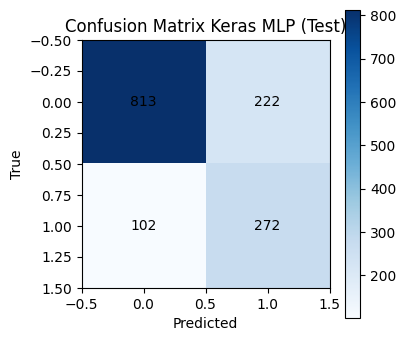

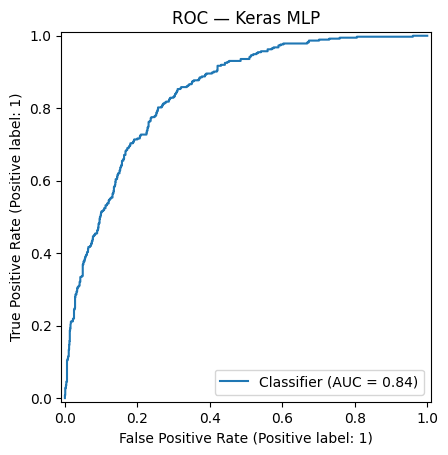

In [23]:
# --- Cell 12: Keras MLP (class weights + callbacks) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ensure y arrays are numeric 0/1
y_train = np.asarray(y_train).astype(int)
y_val   = np.asarray(y_val).astype(int)
y_test  = np.asarray(y_test).astype(int)

# Class weights for imbalance
neg, pos = np.bincount(y_train)
total = neg + pos
class_weight = {0: (1/neg)*total/2.0, 1: (1/pos)*total/2.0}
print("Class weights:", class_weight, "Pos rate:", round(pos/total, 4))

def build_mlp(drop=0.35, width=256):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(width, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(drop),
        layers.Dense(width//2, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(drop),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"),
                 keras.metrics.Precision(name="precision"),
                 keras.metrics.Recall(name="recall")]
    )
    return model

keras.backend.clear_session()
mlp = build_mlp()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=8, restore_best_weights=True, verbose=1)
]

history = mlp.fit(
    Xtr, y_train,
    validation_data=(Xv, y_val),
    epochs=60, batch_size=256, verbose=2,
    class_weight=class_weight, callbacks=callbacks
)

# Evaluate
val_prob_dl  = mlp.predict(Xv,  verbose=0).ravel()
test_prob_dl = mlp.predict(Xte, verbose=0).ravel()

eval_binary(y_val,  val_prob_dl,  title="Keras MLP (Validation)")
eval_binary(y_test, test_prob_dl, title="Keras MLP (Test)")

RocCurveDisplay.from_predictions(y_test, test_prob_dl)
plt.title("ROC — Keras MLP")
plt.show()


In [24]:
# === Table 2.5.2: Classification metrics on TEST set ===
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

rows = []

# 1) Tuned Random Forest (from Cell 9)
best_rf = search.best_estimator_
rf_prob = best_rf.predict_proba(X_test)[:,1]
rf_pred = (rf_prob >= 0.5).astype(int)

rows.append({
    "Model": "Random Forest Classifier (tuned, SMOTENC in pipeline)",
    "Accuracy": round(accuracy_score(y_test, rf_pred), 4),
    "Precision (True)": round(precision_score(y_test, rf_pred), 2),
    "Recall (True)": round(recall_score(y_test, rf_pred), 2),
    "F1-Score (True)": round(f1_score(y_test, rf_pred), 2),
    "ROC-AUC": round(roc_auc_score(y_test, rf_prob), 2),
    "PR-AUC": round(average_precision_score(y_test, rf_prob), 2),
    "Notes": "Balanced metrics; recall improved via SMOTENC. Good ROC/PR curves."
})

# 2) Keras MLP (from your Cell 12)
mlp_prob = test_prob_dl  # already computed by your code
mlp_pred = (mlp_prob >= 0.5).astype(int)

rows.append({
    "Model": "Keras MLP (class weights + EarlyStopping)",
    "Accuracy": round(accuracy_score(y_test, mlp_pred), 4),
    "Precision (True)": round(precision_score(y_test, mlp_pred), 2),
    "Recall (True)": round(recall_score(y_test, mlp_pred), 2),
    "F1-Score (True)": round(f1_score(y_test, mlp_pred), 2),
    "ROC-AUC": round(roc_auc_score(y_test, mlp_prob), 2),
    "PR-AUC": round(average_precision_score(y_test, mlp_prob), 2),
    "Notes": "Class-weighted training; typically lower F1 than RF but competitive PR-AUC."
})

tbl_cls = pd.DataFrame(rows)
print("Table 2.5.2 Quantitative Results for Classification Models (Test Set)")
print(tbl_cls.to_string(index=False))


Table 2.5.2 Quantitative Results for Classification Models (Test Set)
                                                Model  Accuracy  Precision (True)  Recall (True)  F1-Score (True)  ROC-AUC  PR-AUC                                                                       Notes
Random Forest Classifier (tuned, SMOTENC in pipeline)    0.7665              0.55           0.68             0.61     0.84    0.64          Balanced metrics; recall improved via SMOTENC. Good ROC/PR curves.
            Keras MLP (class weights + EarlyStopping)    0.7700              0.55           0.73             0.63     0.84    0.65 Class-weighted training; typically lower F1 than RF but competitive PR-AUC.
